In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
import time


In [2]:
# Cell 2: Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isaiaebongue/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isaiaebongue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isaiaebongue/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/isaiaebongue/nltk_data...


Using device: cpu


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Dataset shape: (4845, 3)
          y                                               text  \
0   neutral  Technopolis plans to develop in stages an area...   
1  negative  The international electronic industry company ...   
2  positive  With the new production plant the company woul...   
3  positive  According to the company 's updated strategy f...   
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...   

                                             text_pt  
0  A Technopolis planeja desenvolver em etapas um...  
1  A Elcoteq, empresa internacional da indÃºstria...  
2  Com a nova planta de produÃ§Ã£o a empresa aume...  
3  De acordo com a estratÃ©gia atualizada da empr...  
4  FINANCIAMENTO DO CRESCIMENTO DA ASPOCOMP A Asp...  


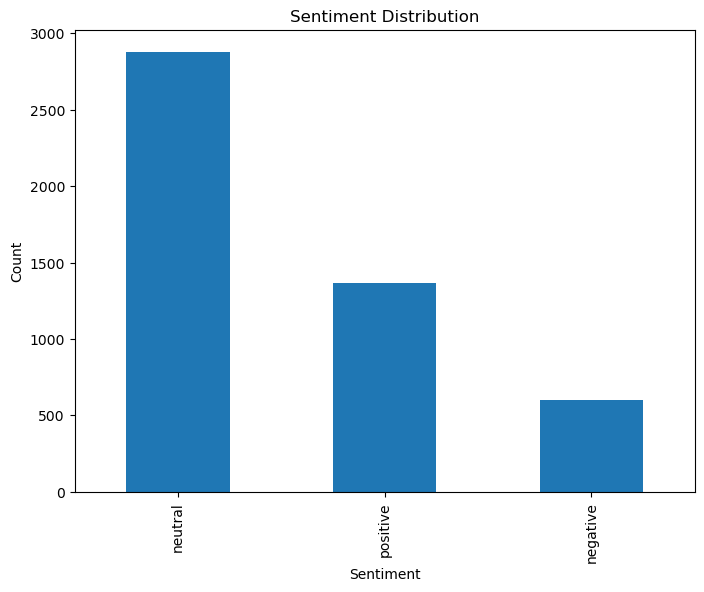

In [6]:
# Cell 3: Load financial sentiment data
# For financial news sentiment dataset similar to your course materials
# You can replace this with your own dataset path
df = pd.read_csv('financial_phrase_bank_pt_br.csv', sep=',', encoding='latin-1')
print(f"Dataset shape: {df.shape}")
print(df.head())

# Check class distribution
plt.figure(figsize=(8, 6))
df['y'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

In [7]:
# Cell 4: Text Preprocessing Functions

def clean_text(text):
    """Basic cleaning of texts."""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

def lemmatize_text(text):
    """Lemmatize text using WordNet lemmatizer."""
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    
    # Get POS tags
    pos_tags = nltk.pos_tag(word_tokens)
    
    # Define mapping from POS tags to WordNet tags
    tag_map = {
        'J': nltk.corpus.wordnet.ADJ,
        'N': nltk.corpus.wordnet.NOUN,
        'V': nltk.corpus.wordnet.VERB,
        'R': nltk.corpus.wordnet.ADV
    }
    
    # Apply lemmatization with POS tag information
    lemmatized_words = []
    for word, tag in pos_tags:
        pos = tag[0].upper()  # Get first letter of POS tag
        wordnet_pos = tag_map.get(pos, nltk.corpus.wordnet.NOUN)  # Default to NOUN
        lemmatized_words.append(lemmatizer.lemmatize(word, wordnet_pos))
    
    return ' '.join(lemmatized_words)

def remove_stopwords(text):
    """Remove stopwords."""
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

def preprocess_text(text):
    """Apply full preprocessing pipeline."""
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text


In [9]:
# Cell 5: Apply preprocessing to the dataset
df['processed_text'] = df['text'].apply(preprocess_text)
print("Text preprocessing complete")
print(df[['text', 'processed_text', 'y']].head())

# Map sentiment labels to integers
# Assuming sentiments are 'positive', 'negative', and 'neutral'
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
df['sentiment_label'] = df['y'].map(sentiment_map)

# Split data into train, validation, and test sets
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment_label'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['sentiment_label'])

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Text preprocessing complete
                                                text  \
0  Technopolis plans to develop in stages an area...   
1  The international electronic industry company ...   
2  With the new production plant the company woul...   
3  According to the company 's updated strategy f...   
4  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...   

                                      processed_text         y  
0  technopolis plan develop stage area less squar...   neutral  
1  international electronic industry company elco...  negative  
2  new production plant company would increase ca...  positive  
3  accord company update strategy year basware ta...  positive  
4  finance aspocomp growth aspocomp aggressively ...  positive  
Training set size: 3391
Validation set size: 727
Test set size: 727


In [10]:
# Cell 6: Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # Number of sentiment classes
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
model.to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

: 